# **Project #4 - Food Recognition**
### Deep Learning course - A.Y. 2020-2021
Students:

- Giuseppe	Murro	(0000997317 $-$ giuseppe.murro@studio.unibo.it)
- Salvatore	Pisciotta	(0000985203 $-$ salvatore.pisciotta2@studio.unibo.it)

## ***TRAINING MODEL B***

### Preliminary settings
Check if the runtime is on Colab

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

Install extern libraries if they are not installed

In [ ]:
!pip install segmentation_models
!pip install visualkeras

Clone the repo in order to access to the dataset if the runtime is on Colab

In [2]:
if IN_COLAB:
    !git clone https://github.com/gmurro/FoodRecognition.git
    %cd /content/FoodRecognition/src
    SRC_PATH = ""
else:
    # Add path of the SRC folder in order to import custom libraries
    import sys
    SRC_PATH = "../../"
    sys.path.insert(1, SRC_PATH)

Import useful libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from utils import segmentation_utils

%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


### Data acquisition
Define the categories of food on which we want train the segmentation model

In [4]:
cat_names = ['water'
             , 'bread-white'
             , 'salad-leaf-salad-green'
             , 'tomato'
             , 'butter'
             , 'carrot'
             , 'coffee-with-caffeine'
             , 'rice'
             , 'egg'
             , 'mixed-vegetables'
             , 'wine-red'
             , 'apple'
             , 'jam'
             , 'potatoes-steamed'
             , 'banana'
             , 'cheese' ]
             
batch_size = 64
img_size = (128,128)
num_classes = len(cat_names) + 1
num_filters = 32

Define the class `DataGenerator`, which will be used for real-time data feeding to our Keras model.
We make the latter inherit the properties of `keras.utils.Sequence` so that we can leverage nice functionalities such as *multiprocessing*.

In [5]:
class DataGenerator(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, coco, batch_size, img_size, img_ids, img_paths, cat_to_class, aug_args=None, shuffle=True):
        self.coco = coco
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_paths = img_paths
        self.img_ids = img_ids
        self.cat_to_class = cat_to_class
        self.aug_args = aug_args
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """ Number of batches per epoch """
        return len(self.img_ids) // self.batch_size

    def __getitem__(self, idx):
        """ Generate one batch of data """

        # Generate indexes of the batch
        indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # n of categories
        n_cat = len(self.cat_to_class)

        # Find list of img paths and image ids to read in the batch
        batch_img_paths = [self.img_paths[i] for i in indexes]
        batch_img_ids = [self.img_ids[i] for i in indexes]

        # load imgs
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype=np.float32)
        for j, path in enumerate(batch_img_paths):
            img = img_to_array(load_img(path, target_size=self.img_size))
            x[j] = img

        # load masks
        y = np.zeros((self.batch_size,) + self.img_size + (n_cat,), dtype=np.float32)
        for j, img_id in enumerate(batch_img_ids):
            mask = segmentation_utils.load_mask(self.coco, img_id, self.cat_to_class)

            # scale down mask
            mask_scaled = np.zeros(self.img_size+ (n_cat,), dtype=np.uint8)
            for i in range(n_cat):
                mask_scaled[:,:,i] = Image.fromarray(mask[:,:,i]).resize(self.img_size, Image.NEAREST)

            y[j] = np.array(mask_scaled, dtype=np.float32)
            
        if self.aug_args is not None:
            x, y = segmentation_utils.augment(x, y, self.aug_args)
            
            #
            
        return x, y

    def on_epoch_end(self):
        """ Method called at the end of every epoch that updates indexes """
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

Show some examples of images from the validation set

In [6]:
# @title Show some images
path_dir = SRC_PATH+"../data/val/"   # @param {type: "string"}

# load images and other info from annotations (filtering only images containing foods in cat_names)
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_class = segmentation_utils.load_imgs(coco, cat_names)

# load all data
x, y = segmentation_utils.load_data(coco, path_dir+"images/", img_size, cat_names)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
Loading images:
550/554 [============================>.] - ETA: 0s
Loading masks:
552/554 [============================>.] - ETA: 0s


Image 316


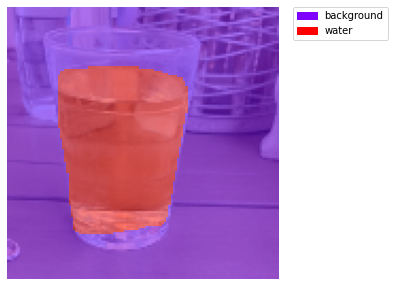

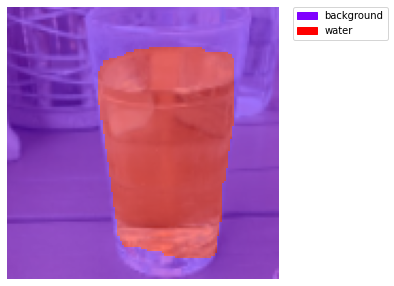


Image 317


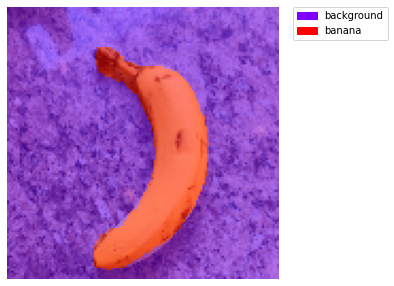

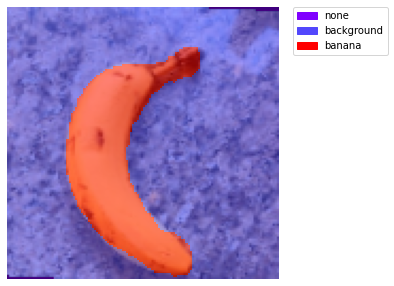


Image 318


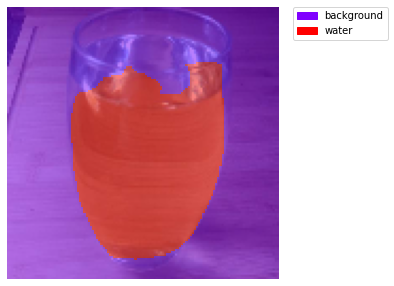

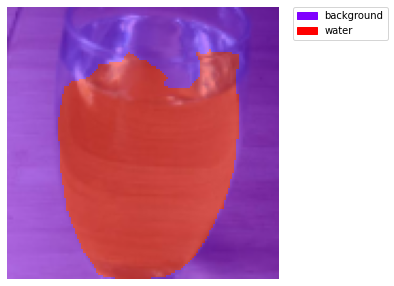

In [7]:
# show 3 random image and compare with augmentation
n = 3

# parameters for the augmetation
aug_args = dict(
                  rotation_range=5              # @param {type:"slider", min:0, max:10, step:1}
                , width_shift_range=0.01        # @param {type:"slider", min:0, max:0.1, step:0.01}
                , height_shift_range=0.01       # @param {type:"slider", min:0, max:0.1, step:0.01}
                , brightness_range=(0.8, 1.2)  
                , shear_range=0.01              # @param {type:"slider", min:0, max:0.1, step:0.01}
                , zoom_range=[0.7, 1]           
                , horizontal_flip=True          # @param {type:"boolean"} 
                , vertical_flip=True            # @param {type:"boolean"} 
                , fill_mode='constant'          #@param ["constant", "nearest", "reflect", "wrap"] {type:"raw"}
                , data_format='channels_last')

idx = random.randint(0, len(x)-1-n)

for i in range(idx,idx+n):
    print("\nImage {}".format(i))

    # show image not augmented
    segmentation_utils.show_mask(x[i,:,:]/255, y[i,:,:,:], cat_names)

    # show the same image augmented
    x_p = x[i].reshape((1,)+x[i].shape)
    y_p = y[i].reshape((1,)+y[i].shape)
    x_aug, y_aug = segmentation_utils.augment(x_p, y_p, aug_args)
    segmentation_utils.show_mask(x_aug[0,:,:]/255, y_aug[0,:,:,:], cat_names)

Instantiate Data Generators for training set **without augmentation**

In [15]:
# @title DataGenerator from training set
path_dir = SRC_PATH+"../data/train/"   # @param {type: "string"}

# load images and other info from annotations (filtering only images containing foods in cat_names)
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_class = segmentation_utils.load_imgs(coco, cat_names)

# compute the class weights
class_dist = segmentation_utils.get_class_dist(coco, cat_names)
class_weights = segmentation_utils.get_class_weights(class_dist)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# create the generator without augmentation
train_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths,  cat_to_class, aug_args=None)

loading annotations into memory...
Done (t=1.73s)
creating index...
index created!


Show class distribution and class weights from the training set. Class weights are computed according to the following formula:

$w(y) = \frac{n\_samples}{n\_classes \cdot counts(y)}$

CLASS WEIGHTS:
	- background: 0.06
	- water: 0.35
	- egg: 1.02
	- butter: 0.63
	- bread-white: 0.50
	- jam: 1.27
	- apple: 1.26
	- cheese: 1.58
	- carrot: 0.71
	- salad-leaf-salad-green: 0.54
	- banana: 1.54
	- mixed-vegetables: 1.02
	- tomato: 0.60
	- wine-red: 1.17
	- rice: 0.97
	- coffee-with-caffeine: 0.73
	- potatoes-steamed: 1.41


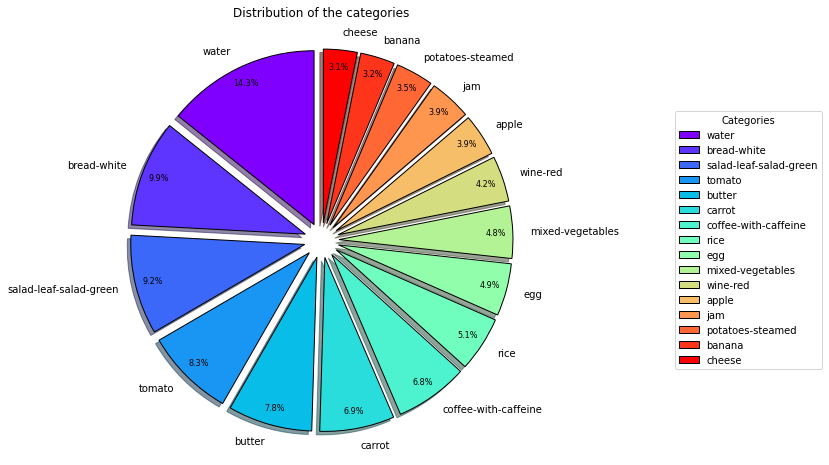

In [16]:
# print class weights
print("CLASS WEIGHTS:")
for i, weight in enumerate(class_weights):
    print("\t- {}: {:.2f}".format(cat_names[i],weight))
    
# plot a pie chart of the class distribution
segmentation_utils.plot_class_dist(class_dist, cat_names, cat_to_class, without_background=True)

Instantiate Data Generators for validation set

In [17]:
# @title DataGenerator from validation set
path_dir = SRC_PATH+"../data/val/"   # @param {type: "string"}

# load images and other info from annotations (filtering only images containing foods in cat_names)
coco = segmentation_utils.load_coco_dataset(path_dir)
img_ids, img_names, cat_names, cat_to_class = segmentation_utils.load_imgs(coco, cat_names)

img_paths = [os.path.join(path_dir+"images/", file_name) for file_name in img_names]

# create the generator
val_gen = DataGenerator(coco, batch_size, img_size, img_ids, img_paths, cat_to_class)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


### Model architecture
Basic U-Net

In [18]:
from tensorflow.keras import layers

def conv_block(input, num_filters, size=3, padding='same', initializer="he_normal"):
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters=num_filters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


def deconv_block(input, num_filters, skip_features, size=2, padding='same', strides=(2, 2)):
    x = layers.Conv2DTranspose(num_filters, kernel_size=(size, size), strides=strides, padding=padding)(input)
    x = layers.concatenate([x, skip_features], axis=3)
    x = conv_block(x, num_filters)
    return x

def unet(img_size, num_classes, num_filters=64):
    
    ''' Input layer '''
    input_layer = layers.Input(shape=img_size + (3,), name='image_input')
    
    ''' Contractive path '''
    ### Layer 1
    conv1 = conv_block(input_layer, num_filters=num_filters)
    conv1_out = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    ### Layer 2
    conv2 = conv_block(conv1_out, num_filters=num_filters*2)
    conv2_out = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    ### Layer 3
    conv3 = conv_block(conv2_out, num_filters=num_filters*4)
    conv3_out = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    ### Layer 4
    conv4 = conv_block(conv3_out, num_filters=num_filters*8)
    conv4_out = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = layers.Dropout(0.5)(conv4_out)
    
    ### Layer 5
    conv5 = conv_block(conv4_out, num_filters=num_filters*16)
    conv5 = layers.Dropout(0.5)(conv5)
    
    ''' Expansive path '''
    ### Layer 6
    deconv6 = deconv_block(conv5, num_filters=num_filters*8, skip_features=conv4)
    deconv6 = layers.Dropout(0.5)(deconv6)
    
    ### Layer 7
    deconv7 = deconv_block(deconv6, num_filters=num_filters*4, skip_features=conv3,)
    
    ### Layer 8
    deconv8 = deconv_block(deconv7, num_filters=num_filters*2, skip_features=conv2)
    
    ### Layer 9
    deconv9 = deconv_block(deconv8, num_filters=num_filters, skip_features=conv1)
    
    # output: add a per-pixel classification layer
    output_layer = layers.Conv2D(filters=num_classes, kernel_size=(1, 1), activation="sigmoid", padding="same")(deconv9)
    
    # Define the model
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='u-net')
    return model

# Free up RAM in case the model definition cells were run multiple times
tf.keras.backend.clear_session()

# Build model
model = unet(img_size, num_classes, num_filters=num_filters)
model.summary()

Model: "u-net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

Draw model architecture

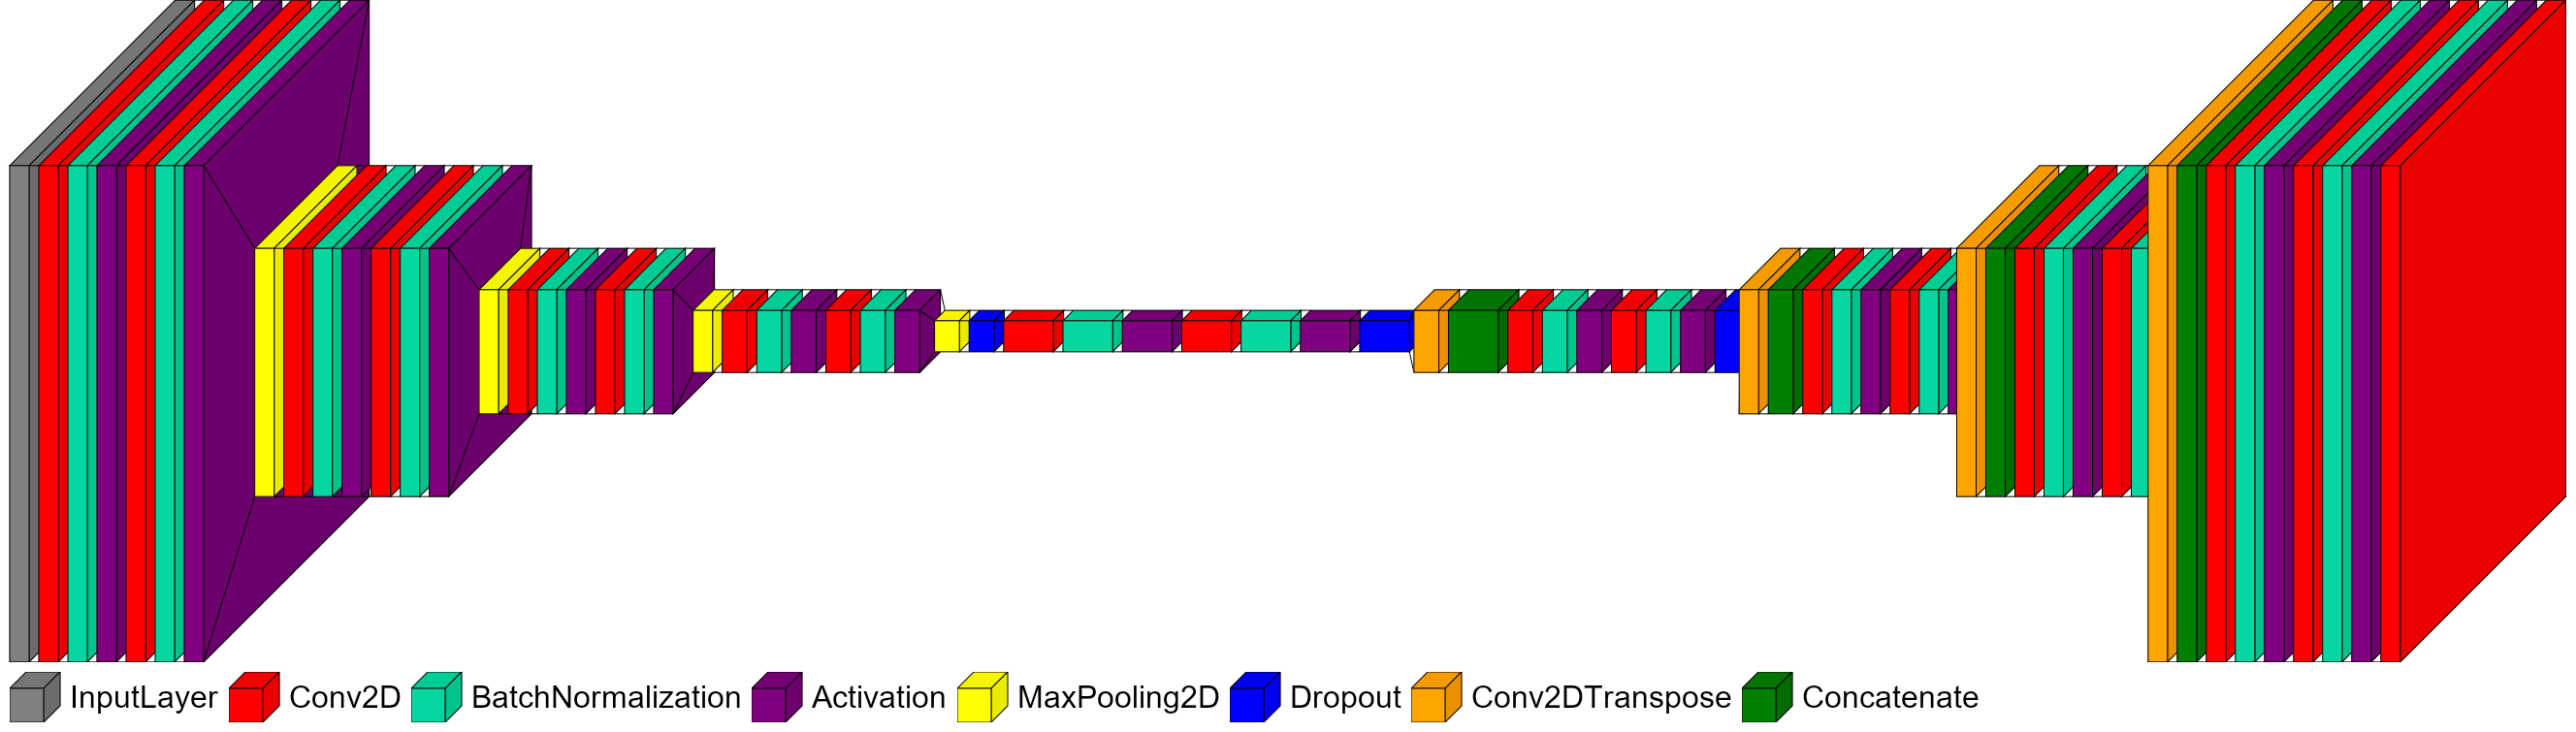

In [13]:
import visualkeras
from PIL import ImageFont
from collections import defaultdict

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'red'
color_map[layers.InputLayer]['fill'] = 'gray'
color_map[layers.Dropout]['fill'] = 'blue'
color_map[layers.MaxPooling2D]['fill'] = 'yellow'
color_map[layers.Concatenate]['fill'] = 'green'
color_map[layers.Activation]['fill'] = 'purple'
color_map[layers.Conv2DTranspose]['fill'] = 'orange'


font = ImageFont.truetype("arial.ttf", 32)  
visualkeras.layered_view(model, legend=True, font=font, color_map=color_map) 

### Training phase
Configure the model for the training

In [19]:
# Combo loss 
loss = sm.losses.BinaryFocalLoss() + sm.losses.DiceLoss(class_weights=class_weights)

threshold = 0.5
metrics = [  sm.metrics.IOUScore(threshold=threshold)
           , sm.metrics.Precision(threshold=threshold)
           , sm.metrics.Recall(threshold=threshold)
           , sm.metrics.FScore(threshold=threshold)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
              , loss=loss
              , metrics=metrics)

In [14]:
cp_file_name = "weights_model_B_80e.h5"

callbacks = [
    # Model checkpoint save weights ad other informations
    tf.keras.callbacks.ModelCheckpoint(  cp_file_name 
                                       , monitor = 'loss'    # Select which quantity to refers, can also use metrics or the validation 
                                       , verbose = 1
                                       , save_best_only = True 
                                       , mode = 'auto' 
                                       , save_freq = 'epoch' # Flag to save at each epoch 
                                       )
    , tf.keras.callbacks.TensorBoard(log_dir="tensorboard_model_B")
]

# Train the model, doing validation at the end of each epoch.
epochs = 80
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/80
169/169 [==============================] - 773s 5s/step - loss: 1.0467 - mean_io_u: 0.4704 - iou_score: 0.0481 - precision: 0.1047 - recall: 0.2091 - f1-score: 0.0669 - val_loss: 0.9983 - val_mean_io_u: 0.4703 - val_iou_score: 0.0518 - val_precision: 0.3208 - val_recall: 0.1595 - val_f1-score: 0.0807

Epoch 00001: loss improved from inf to 1.01260, saving model to model\food_segmentation_80_epochs_sigmoid_binary_focal_dice_loss_no_aug_128_class_weights_adam_64_filters_20210611-152501.h5
Epoch 2/80
169/169 [==============================] - 765s 5s/step - loss: 0.9670 - mean_io_u: 0.4704 - iou_score: 0.1163 - precision: 0.3331 - recall: 0.2192 - f1-score: 0.1685 - val_loss: 1.0032 - val_mean_io_u: 0.4705 - val_iou_score: 0.0660 - val_precision: 0.2609 - val_recall: 0.2134 - val_f1-score: 0.1109

Epoch 00002: loss improved from 1.01260 to 0.95267, saving model to model\food_segmentation_80_epochs_sigmoid_binary_focal_dice_loss_no_aug_128_class_weights_adam_64_filters_20210611-

169/169 [==============================] - 772s 5s/step - loss: 0.5875 - mean_io_u: 0.4705 - iou_score: 0.4048 - precision: 0.5679 - recall: 0.5563 - f1-score: 0.5281 - val_loss: 0.7341 - val_mean_io_u: 0.4704 - val_iou_score: 0.2979 - val_precision: 0.6065 - val_recall: 0.3937 - val_f1-score: 0.3879

Epoch 00033: loss improved from 0.59955 to 0.59566, saving model to model\food_segmentation_80_epochs_sigmoid_binary_focal_dice_loss_no_aug_128_class_weights_adam_64_filters_20210611-152501.h5
Epoch 34/80
169/169 [==============================] - 773s 5s/step - loss: 0.6032 - mean_io_u: 0.4706 - iou_score: 0.3945 - precision: 0.5529 - recall: 0.5584 - f1-score: 0.5160 - val_loss: 0.6645 - val_mean_io_u: 0.4707 - val_iou_score: 0.3324 - val_precision: 0.5643 - val_recall: 0.4490 - val_f1-score: 0.4466

Epoch 00034: loss did not improve from 0.59566
Epoch 35/80
169/169 [==============================] - 772s 5s/step - loss: 0.5954 - mean_io_u: 0.4706 - iou_score: 0.4023 - precision: 0.5591


Epoch 00068: loss improved from 0.48073 to 0.47432, saving model to model\food_segmentation_80_epochs_sigmoid_binary_focal_dice_loss_no_aug_128_class_weights_adam_64_filters_20210611-152501.h5
Epoch 69/80
169/169 [==============================] - 771s 5s/step - loss: 0.4607 - mean_io_u: 0.4706 - iou_score: 0.5276 - precision: 0.6907 - recall: 0.6706 - f1-score: 0.6490 - val_loss: 0.6102 - val_mean_io_u: 0.4709 - val_iou_score: 0.3995 - val_precision: 0.5972 - val_recall: 0.5417 - val_f1-score: 0.5148

Epoch 00069: loss improved from 0.47432 to 0.46562, saving model to model\food_segmentation_80_epochs_sigmoid_binary_focal_dice_loss_no_aug_128_class_weights_adam_64_filters_20210611-152501.h5
Epoch 70/80
169/169 [==============================] - 771s 5s/step - loss: 0.4777 - mean_io_u: 0.4707 - iou_score: 0.5210 - precision: 0.6806 - recall: 0.6726 - f1-score: 0.6422 - val_loss: 0.5849 - val_mean_io_u: 0.4707 - val_iou_score: 0.4249 - val_precision: 0.6601 - val_recall: 0.5342 - val_f

### History of the training
Plot metrics evolution from 0 to 80 epoch during the training

In [15]:
import matplotlib.pyplot as plt
def plot_history(model_history, keys, labels=("epochs", "metrics"), figsize=(10,5)):
    
    fig = plt.figure(figsize=figsize)
    
    # take all pairs of training and val metrics
    for i in range(0, len(keys), 2):
        m, val_m = keys[i], keys[i+1]
        
        plt.plot(model_history.history[m])
        plt.plot(model_history.history[val_m])
        
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])

    # Adding legend
    plt.legend(keys,
          title ="Legend",
          loc ="upper left",
          bbox_to_anchor =(1.0, 0, 0.5, 1))
    plt.title("Training history")
    plt.grid(True)
    plt.show()

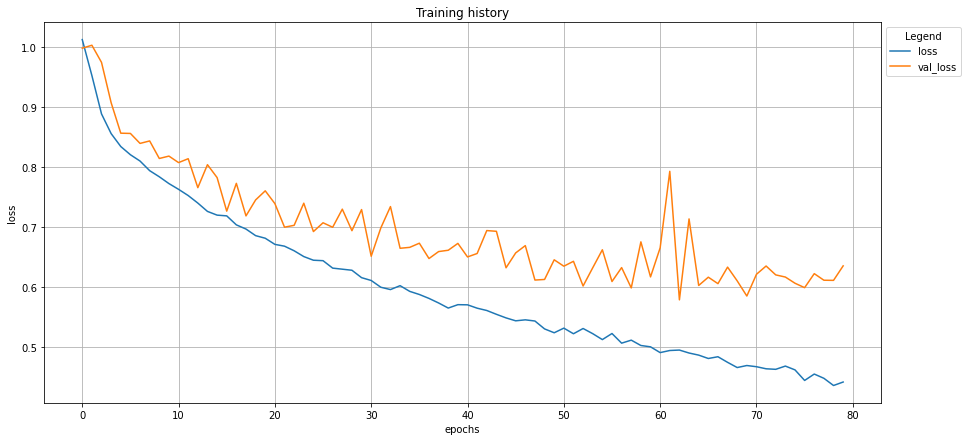

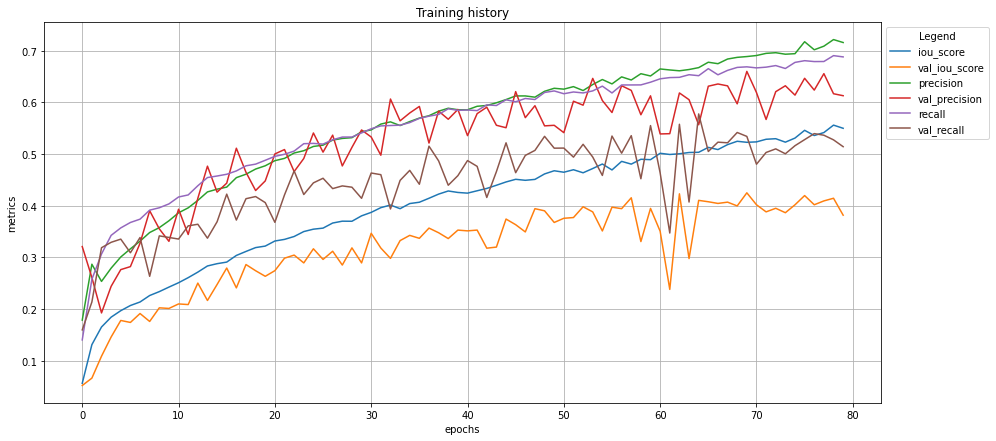

In [16]:
# plot history
plot_history(history,['loss','val_loss'], labels=("epochs", "loss"), figsize=(15,7))
plot_history(history,['iou_score','val_iou_score', 'precision', 'val_precision', 'recall', 'val_recall'], figsize=(15,7))

Store model and history on files

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model_B.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 
with open("train_history_model_B.csv", mode="w") as file:
    hist_df.to_csv(file)